<a href="https://colab.research.google.com/github/rachelresende/titanic/blob/main/Desafio_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão logística com Python (WIP)

Para este notebook, estarei apresentando um trabalho com o [Conjunto de dados do Titanic da Kaggle](https://www.kaggle.com/c/titanic). Este é um conjunto de dados muito famoso e muitas vezes é o primeiro passo em Machine Learning!

Vou tentar montar um algoritmo de classificação sobrevivente ou falecido utilizando regressão logística no Python. Vale lembrar que a regressão logística é um modelo de função entre 0 e 1 e por isso foi escolhida como método de previsão de classificação ao invés da linear.

## Importar bibliotecas
Vamos importar algumas bibliotecas para começar!

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


## Vou agora observar e explorar um pouco os dados antes de iniciar a regressão

In [ ]:
train = pd.read_csv("/content/titanic_train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train.isnull()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
886,False,False,False,False,False,False,False,False,False,False,True,False
887,False,False,False,False,False,False,False,False,False,False,False,False
888,False,False,False,False,False,True,False,False,False,False,True,False
889,False,False,False,False,False,False,False,False,False,False,False,False


## Percebemos dados faltantes em cabines a partir do ISNULL

Aproximadamente 20% dos dados de idade estão faltando. A proporção de idade que falta é provavelmente pequena o suficiente para que possamos fazer uma substituição razoável com alguma forma de imputação de dados. Olhando para a coluna Cabin, porém, parece que estamos perdendo muito desses dados para fazermos o mesmo. Provavelmente vamos descartar isso mais tarde ou mudá-lo para outro "Cabin Conhecido: 1 ou 0"

Continuemos visualizando mais alguns dos dados! Confira o vídeo para obter explicações completas sobre esses gráficos, este código é apenas para servir como referência.

<Axes: >

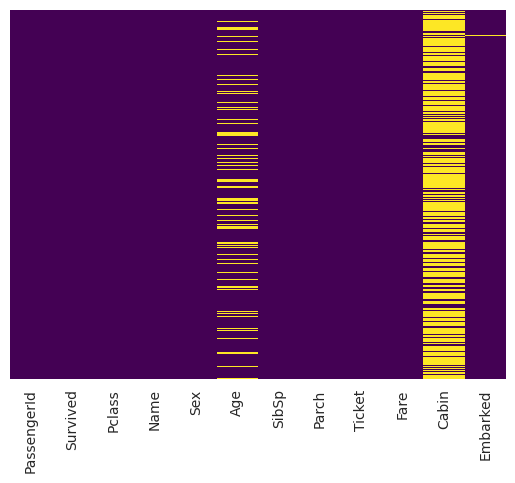

In [ ]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

<ipython-input-77-05742e5567b5>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Survived',data=train,palette='RdBu_r')


<Axes: xlabel='Survived', ylabel='count'>

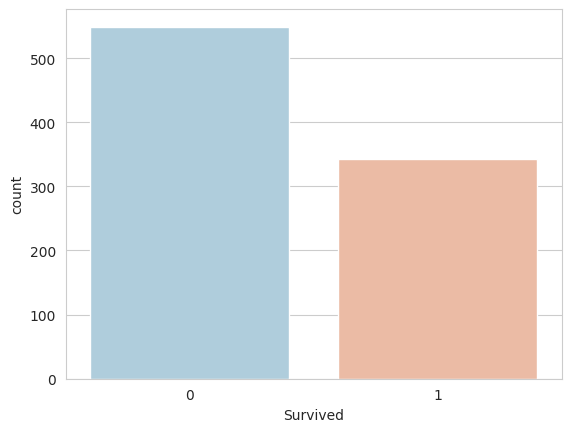

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train,palette='RdBu_r')

<Axes: xlabel='Survived', ylabel='count'>

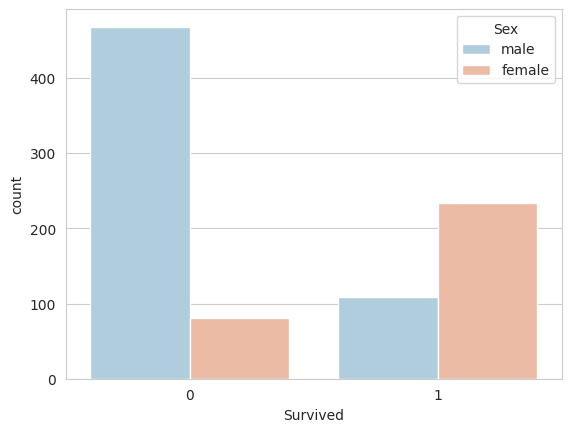

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

<Axes: xlabel='Survived', ylabel='count'>

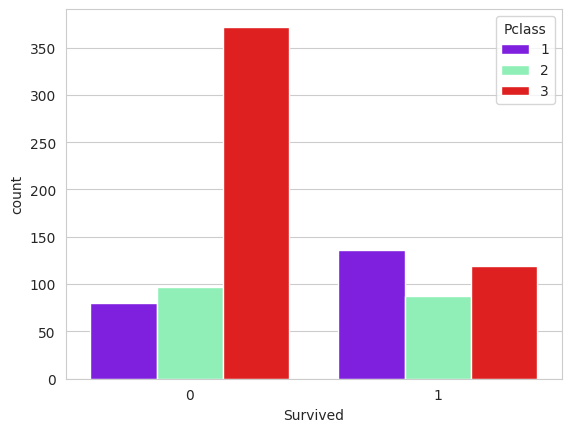

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

<Axes: >

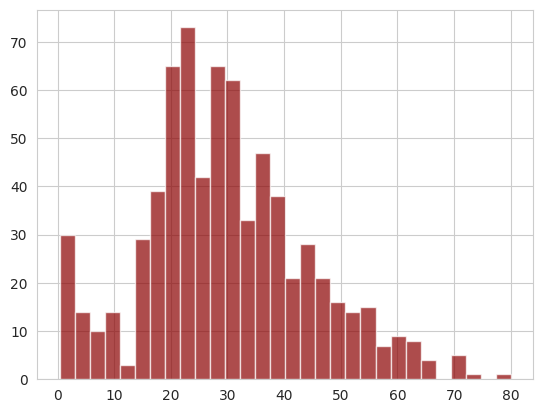

In [ ]:
train['Age'].hist(bins=30,color='darkred',alpha=0.7)

<ipython-input-81-53c281d34688>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['Age'].dropna(),kde=False,color='darkred',bins=30)


<Axes: xlabel='Age'>

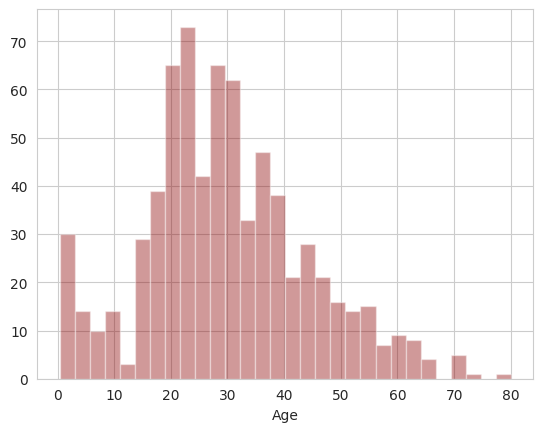

In [ ]:
sns.distplot(train['Age'].dropna(),kde=False,color='darkred',bins=30)

<Axes: xlabel='SibSp', ylabel='count'>

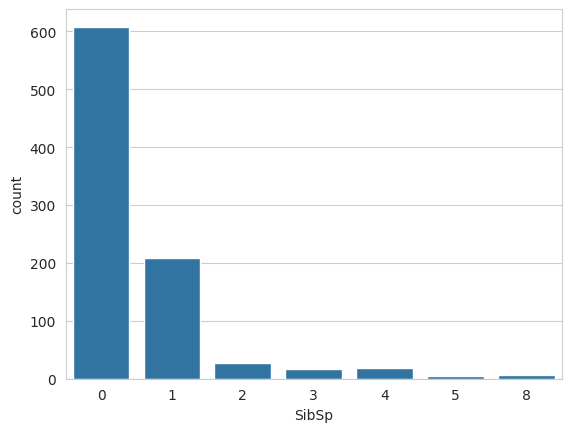

In [ ]:
sns.countplot(x='SibSp',data=train)

<Axes: >

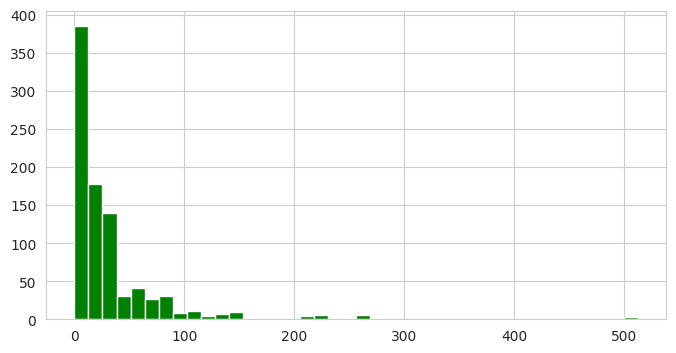

In [ ]:
train['Fare'].hist(color='green',bins=40,figsize=(8,4))

## Interpretando os dados faltantes e preenchendo os relevantes

Queremos preencher dados de idade faltantes, em vez de simplesmente deixar cair as linhas de dados de idade que faltam. Uma maneira de fazer isso é preenchendo a idade média de todos os passageiros (imputação). No entanto, podemos ser mais inteligentes sobre isso e verificar a idade média pela classe de passageiros. Por exemplo:

<ipython-input-84-551bc5ec5847>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')


<Axes: xlabel='Pclass', ylabel='Age'>

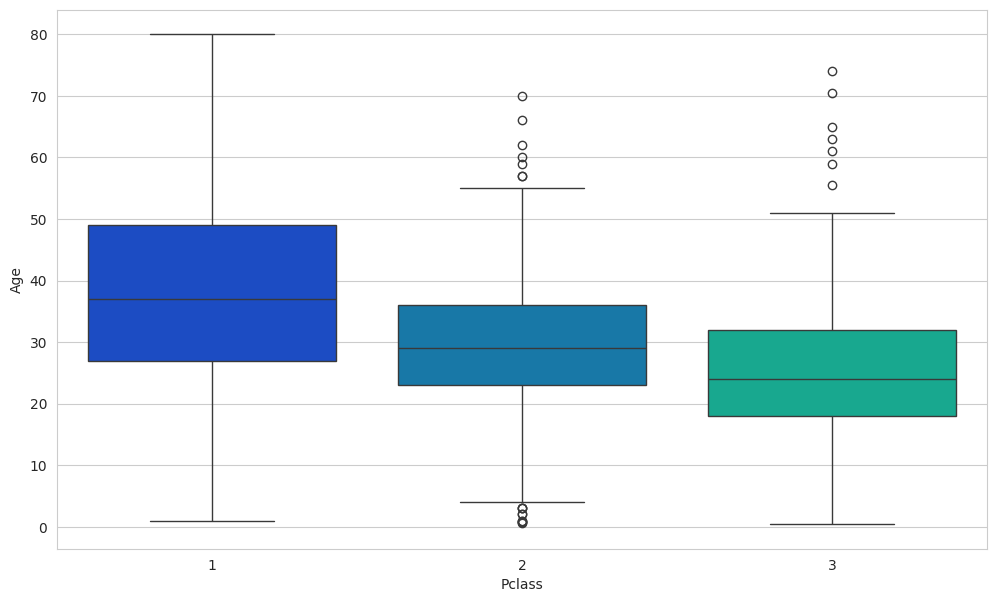

In [ ]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

Podemos ver os passageiros mais ricos nas (que estão nas classes superiores) tendem a ser mais velhos, o que faz sentido. Usaremos esses valores de idade média para imputar com base em Pclass for Age. Vamos guardar essa informação para o preenchimento dos dados de idade que vieram faltando no dataset de treino.

In [ ]:
def impute_age(cols): ##função referente ao preenchimento das idades
    Age = cols[0]
    Pclass = cols[1]

    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

##Aplicando a Função

Repare que após o uso da função, preenchemos os dados de idade que estavam faltando

In [ ]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)

<ipython-input-85-918d0e6a3735>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Age = cols[0]
<ipython-input-85-918d0e6a3735>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Pclass = cols[1]


<Axes: >

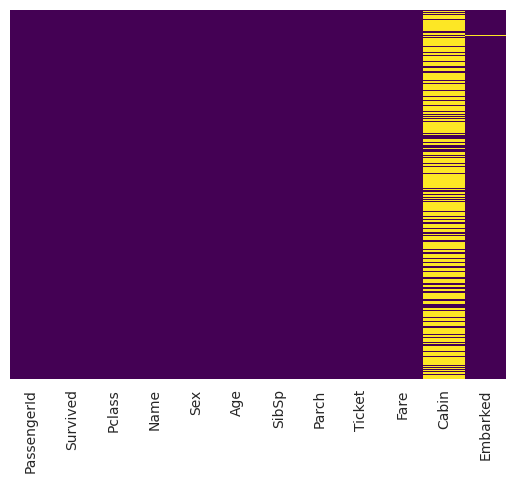

In [ ]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Ótimo! Vamos seguir em frente e deletar a coluna Cabin e a linha em Embarked

---

que falta dado.

In [ ]:
train.drop('Cabin',axis=1,inplace=True) ##cabines faltantes sem necessidade para a análise
train.head()
train.dropna(inplace=True) #um dado de embarque faltante

## Convertendo recursos categóricos

Precisamos converter características categóricas em variáveis dummy usando pandas! Caso contrário, nosso algoritmo de Machine Learning não será capaz de aceitar esses recursos diretamente como entradas.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [ ]:
sex = pd.get_dummies(train['Sex'],drop_first=True)  # drop_first=True > Para evitar a multi-colinaridade
embark = pd.get_dummies(train['Embarked'],drop_first=True)
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)
train = pd.concat([train,sex,embark],axis=1)
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,True,False,True
1,2,1,1,38.0,1,0,71.2833,False,False,False
2,3,1,3,26.0,0,0,7.9250,False,False,True
3,4,1,1,35.0,1,0,53.1000,False,False,True
4,5,0,3,35.0,0,0,8.0500,True,False,True


Ótimo! Nossos dados estão prontos para o nosso modelo

---



# Construindo um modelo de Regressão Logística

Vamos começar dividindo nossos dados em um conjunto de treinamento e conjunto de testes (há outro arquivo test.csv que você pode usar ao invés, caso queira usar todos esses dados para treinar).

## Divisão treino-teste

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1),
                                                    train['Survived'], test_size=0.30,
                                                    random_state=101)

## Training and Predicting




In [ ]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Avaliação

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.79      0.91      0.85       163
           1       0.81      0.62      0.71       104

    accuracy                           0.80       267
   macro avg       0.80      0.77      0.78       267
weighted avg       0.80      0.80      0.79       267

